<a href="https://colab.research.google.com/github/vadhri/hpc-notebook/blob/main/PDE/Monte-Carlo/Metropolis_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Website: https://alps.comp-phys.org

!apt-get install libgsl-dev -q

Reading package lists...
Building dependency tree...
Reading state information...
libgsl-dev is already the newest version (2.7.1+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


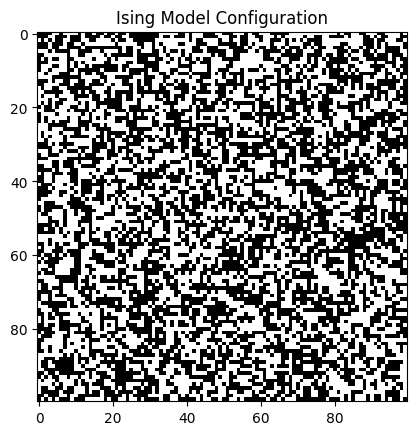

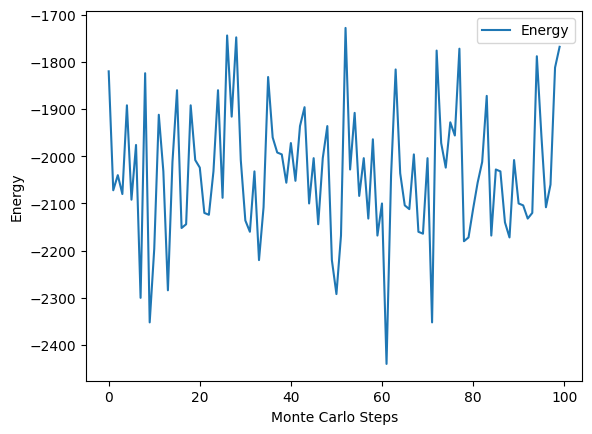

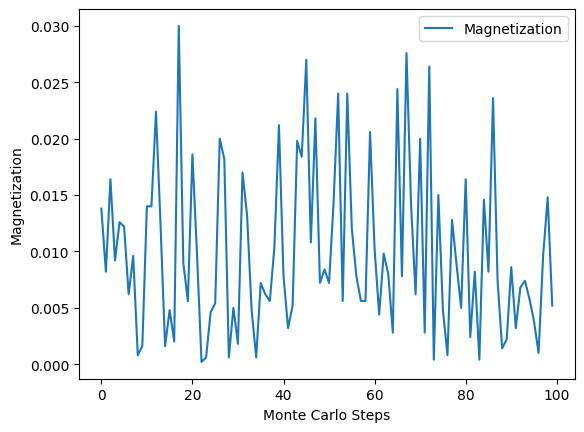

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_lattice(L):
    """Initialize an LxL lattice with random spins (+1 or -1)."""
    return np.random.choice([-1, 1], size=(L, L))

def compute_energy(lattice):
    """Compute the total energy of the lattice."""
    energy = 0
    L = lattice.shape[0]
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
            energy += -S * neighbors
    return energy / 2  # Each bond is counted twice

def metropolis_step(lattice, beta):
    """Perform one Metropolis step."""
    L = lattice.shape[0]
    for _ in range(L**2):  # Sweep through the entire lattice
        i, j = np.random.randint(0, L, size=2)
        S = lattice[i, j]
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
        dE = 2 * S * neighbors
        if dE < 0 or (np.random.rand() < np.exp(-beta * dE)):
            lattice[i, j] *= -1

def monte_carlo_simulation(L, T, steps):
    """Run the Monte Carlo simulation for a given temperature T and steps."""
    beta = 1.0 / T
    lattice = initialize_lattice(L)
    energies = []
    magnetizations = []

    for step in range(steps):
        metropolis_step(lattice, beta)
        energy = compute_energy(lattice)
        magnetization = np.abs(np.sum(lattice)) / (L * L)

        energies.append(energy)
        magnetizations.append(magnetization)

    return energies, magnetizations, lattice

def plot_lattice(lattice):
    """Plot the spin lattice."""
    plt.imshow(lattice, cmap='gray')
    plt.title("Ising Model Configuration")
    plt.show()

# Parameters
L = 100       # Lattice size
T = 10     # Temperature
steps = 100 # Number of Monte Carlo steps

energies, magnetizations, final_lattice = monte_carlo_simulation(L, T, steps)

# Plot results
plot_lattice(final_lattice)
plt.figure()
plt.plot(energies, label='Energy')
plt.xlabel("Monte Carlo Steps")
plt.ylabel("Energy")
plt.legend()
plt.show()

plt.figure()
plt.plot(magnetizations, label='Magnetization')
plt.xlabel("Monte Carlo Steps")
plt.ylabel("Magnetization")
plt.legend()
plt.show()


In [26]:
%%writefile metropolis_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <gsl/gsl_rng.h>
#include <cuda_runtime.h>
#include <curand_kernel.h>

#define L 100
#define J 1.0f
#define kT 10.0f
#define SWEEPS 100

__global__ void init_rng(curandState *d_rand_states, unsigned long seed) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < L * L) {
        curand_init(seed, idx, 0, &d_rand_states[idx]);
    }
}

__global__ void metropolis_step_cuda(int *d_lattice, curandState *d_rand_states) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx >= L * L) return;

    int x = idx / L;
    int y = idx % L;

    int left = d_lattice[((x - 1 + L) % L) * L + y];
    int right = d_lattice[((x + 1) % L) * L + y];
    int up = d_lattice[x * L + ((y + 1) % L)];
    int down = d_lattice[x * L + ((y - 1 + L) % L)];

    int spin = d_lattice[x * L + y];
    int dE = 2 * J * spin * (left + right + up + down);

    curandState localState = d_rand_states[idx];
    float randVal = curand_uniform(&localState);
    d_rand_states[idx] = localState;  // Save state back

    if (dE < 0 || randVal < expf(-dE / kT)) {
        atomicExch(&d_lattice[x * L + y], -spin);
    }
}

void initialize_lattice(int *lattice) {
    gsl_rng *rng = gsl_rng_alloc(gsl_rng_mt19937);
    gsl_rng_set(rng, 1234);
    for (int i = 0; i < L * L; i++) {
        lattice[i] = (gsl_rng_uniform(rng) < 0.5) ? 1 : -1;
    }
    gsl_rng_free(rng);
}

float compute_energy(int *lattice) {
    float energy = 0.0f;
    for (int x = 0; x < L; x++) {
        for (int y = 0; y < L; y++) {
            int S = lattice[x * L + y];
            int right = lattice[((x + 1) % L) * L + y];
            int down = lattice[x * L + ((y + 1) % L)];
            energy += -J * S * (right + down);
        }
    }
    return energy;
}

float compute_magnetization(int *lattice) {
    int sum = 0;
    for (int i = 0; i < L * L; i++) {
        sum += lattice[i];
    }
    return (float)sum / (L * L);
}

void simulate() {
    int *h_lattice = (int *)malloc(L * L * sizeof(int));
    initialize_lattice(h_lattice);

    int *d_lattice;
    curandState *d_rand_states;
    cudaMalloc(&d_lattice, L * L * sizeof(int));
    cudaMalloc(&d_rand_states, L * L * sizeof(curandState));
    cudaMemcpy(d_lattice, h_lattice, L * L * sizeof(int), cudaMemcpyHostToDevice);

    dim3 blockSize(256);
    dim3 gridSize((L * L + blockSize.x - 1) / blockSize.x);

    init_rng<<<gridSize, blockSize>>>(d_rand_states, 1234);
    cudaDeviceSynchronize();

    FILE *outputFile = fopen("energy_magnetization.txt", "w");

    for (int i = 0; i < SWEEPS; i++) {
        metropolis_step_cuda<<<gridSize, blockSize>>>(d_lattice, d_rand_states);
        cudaDeviceSynchronize();
        cudaMemcpy(h_lattice, d_lattice, L * L * sizeof(int), cudaMemcpyDeviceToHost);

        float energy = compute_energy(h_lattice);
        float magnetization = compute_magnetization(h_lattice);
        fprintf(outputFile, "%d %.6f %.6f\n", i, energy, magnetization);

        if (i % (SWEEPS / 10) == 0) {
            printf("Sweep %d: Energy = %.2f, Magnetization = %.2f\n", i, energy, magnetization);
        }
    }

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA Error: %s\n", cudaGetErrorString(err));
    }

    fclose(outputFile);
    cudaFree(d_lattice);
    cudaFree(d_rand_states);
    free(h_lattice);
}

int main() {
    simulate();
    return 0;
}


Overwriting metropolis_cuda.cu


In [27]:
!nvcc -arch=sm_75 -gencode arch=compute_75,code=sm_75 metropolis_cuda.cu -o metropolis_cuda -lgsl -lgslcblas -lm
!time ./metropolis_cuda

Sweep 0: Energy = 4872.00, Magnetization = 0.01
Sweep 10: Energy = 11664.00, Magnetization = 0.00
Sweep 20: Energy = 12028.00, Magnetization = 0.00
Sweep 30: Energy = 12068.00, Magnetization = 0.00
Sweep 40: Energy = 12076.00, Magnetization = 0.00
Sweep 50: Energy = 12076.00, Magnetization = 0.00
Sweep 60: Energy = 12076.00, Magnetization = 0.00
Sweep 70: Energy = 12076.00, Magnetization = 0.00
Sweep 80: Energy = 12076.00, Magnetization = 0.00
Sweep 90: Energy = 12076.00, Magnetization = 0.00

real	0m0.241s
user	0m0.027s
sys	0m0.210s


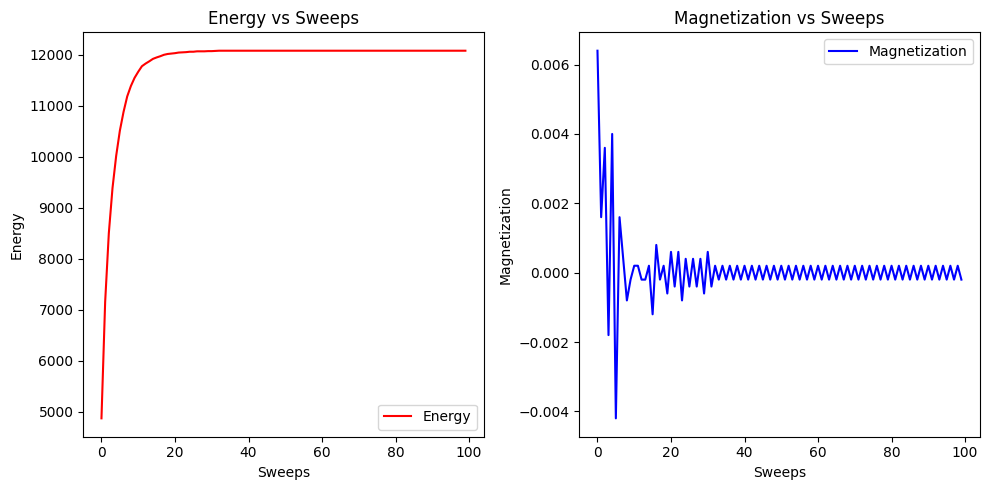

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from file
data = np.loadtxt("energy_magnetization.txt")

# Extract sweep numbers, energy, and magnetization
sweeps = data[:, 0]
energy = data[:, 1]
magnetization = data[:, 2]

# Plot Energy vs Sweeps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sweeps, energy, label="Energy", color='r')
plt.xlabel("Sweeps")
plt.ylabel("Energy")
plt.title("Energy vs Sweeps")
plt.legend()

# Plot Magnetization vs Sweeps
plt.subplot(1, 2, 2)
plt.plot(sweeps, magnetization, label="Magnetization", color='b')
plt.xlabel("Sweeps")
plt.ylabel("Magnetization")
plt.title("Magnetization vs Sweeps")
plt.legend()

plt.tight_layout()
plt.show()
